In [9]:
# Install packages for project
# This has been commented as these packages have already been installed.

# %pip install pandas
# %pip install deep-translator
# %pip install google_trans_new
# %pip install google-cloud-translate==2.0.1
# %pip install trrex
# %pip install vaderSentiment


#Importing libraries

import glob
import pandas as pd
import numpy as np
from pandas import read_csv
from deep_translator import GoogleTranslator
from nltk import word_tokenize
import re
from collections import Counter
import eli5 as e5
import nltk
import csv
from nltk.corpus import stopwords
import pandas as pd
import trrex as tx
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.stem.wordnet import WordNetLemmatizer
wordnet = WordNetLemmatizer()

nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to C:\Users\Game
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Game
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# small function to easily read text files

def read_txt(file_path, delimiter=None):
    content = ' '
    with open(file_path) as f:
        content = f.read().splitlines()

    if delimiter != None:
        content = content.split(delimiter)
    return content

In [3]:
# New csv CORONA

corona_train_csv = pd.read_csv ('./data/Corona_NLP_train.csv', encoding="latin-1", on_bad_lines='skip', delimiter = ',')
corona_test_csv = pd.read_csv ('./data/Corona_NLP_test.csv', encoding="latin-1", on_bad_lines='skip', delimiter = ',')
corona_csv = pd.concat([corona_train_csv, corona_test_csv])

In [6]:
corona_csv.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [25]:
# # read csv file
# OLD!

# csv = pd.read_csv ('./data/McDonalds-Yelp-Sentiment-DFE.csv', encoding="latin-1", on_bad_lines='skip', delimiter = ',')
opinion_words = read_txt('./data/opinion-lexicon-English/opinion-words.txt')
positive_words = read_txt('./data/opinion-lexicon-English/positive-words.txt')
negative_words = read_txt('./data/opinion-lexicon-English/negative-words.txt')
# colums = csv.columns
# print(colums)

# csv.head(5)

In [11]:
def lemmatize(input):
    lemmatized = []
    for token in input:
        lemmatized.append(wordnet.lemmatize(token))
    return lemmatized

In [12]:
# Remove special characters and stopwords

stop = stopwords.words('english')
corona_csv["OriginalTweet"] = corona_csv["OriginalTweet"].apply(lambda x: " ".join(x.lower() for x in str(x).split() if x not in stop))

corona_csv["OriginalTweet"] = corona_csv["OriginalTweet"].map(lambda x: re.sub(r'[^A-Za-z0-9 ]+', '', x))
corona_csv.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,OriginalTweet-tokenized
0,3799,48751,London,16-03-2020,menyrbie philgahan chrisitv httpstcoifz9fan2pa...,Neutral,"[menyrbie, philgahan, chrisitv, httpstcoifz9fa..."
1,3800,48752,UK,16-03-2020,advice talk neighbours family exchange phone n...,Positive,"[advice, talk, neighbours, family, exchange, p..."
2,3801,48753,Vagabonds,16-03-2020,coronavirus australia woolworths give elderly ...,Positive,"[coronavirus, australia, woolworths, give, eld..."
3,3802,48754,NaN,16-03-2020,food stock one empty please panic enough food ...,Positive,"[my, food, stock, one, empty, please, panic, t..."
4,3803,48755,NaN,16-03-2020,ready go supermarket covid19 outbreak im paran...,Extremely Negative,"[me, ready, go, supermarket, covid19, outbreak..."


In [13]:
# Tokenize the reviews and add them as a seperate column
corona_csv["OriginalTweet-tokenized"] = corona_csv["OriginalTweet"].apply(lambda x : nltk.word_tokenize(x))
corona_csv["OriginalTweet-lemmatized"] = corona_csv["OriginalTweet-tokenized"].apply(lambda x : lemmatize(x))

# OLD CODE!
# csv['policies_violated'] = csv['policies_violated'].apply(lambda x : re.split('\r', str(x)))
# csv['policies_violated:confidence'] = csv['policies_violated:confidence'].apply(lambda x : [float(x.strip(' []')) for x in re.split('\r', str(x))])

corona_csv.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,OriginalTweet-tokenized,OriginalTweet-lemmatized
0,3799,48751,London,16-03-2020,menyrbie philgahan chrisitv httpstcoifz9fan2pa...,Neutral,"[menyrbie, philgahan, chrisitv, httpstcoifz9fa...","[menyrbie, philgahan, chrisitv, httpstcoifz9fa..."
1,3800,48752,UK,16-03-2020,advice talk neighbours family exchange phone n...,Positive,"[advice, talk, neighbours, family, exchange, p...","[advice, talk, neighbour, family, exchange, ph..."
2,3801,48753,Vagabonds,16-03-2020,coronavirus australia woolworths give elderly ...,Positive,"[coronavirus, australia, woolworths, give, eld...","[coronavirus, australia, woolworth, give, elde..."
3,3802,48754,NaN,16-03-2020,food stock one empty please panic enough food ...,Positive,"[food, stock, one, empty, please, panic, enoug...","[food, stock, one, empty, please, panic, enoug..."
4,3803,48755,NaN,16-03-2020,ready go supermarket covid19 outbreak im paran...,Extremely Negative,"[ready, go, supermarket, covid19, outbreak, im...","[ready, go, supermarket, covid19, outbreak, im..."


In [23]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
corona_csv['compound'] = [analyzer.polarity_scores(x)['compound'] for x in         
corona_csv["OriginalTweet"]]
corona_csv['neg'] = [analyzer.polarity_scores(x)['neg'] for x in         
corona_csv["OriginalTweet"]]
corona_csv['neu'] = [analyzer.polarity_scores(x)['neu'] for x in         
corona_csv["OriginalTweet"]]
corona_csv['pos'] = [analyzer.polarity_scores(x)['pos'] for x in         
corona_csv["OriginalTweet"]]

corona_csv.head(20)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,OriginalTweet-tokenized,OriginalTweet-lemmatized,compound,neg,neu,pos,evaluation
0,3799,48751,London,16-03-2020,menyrbie philgahan chrisitv httpstcoifz9fan2pa...,Neutral,"[menyrbie, philgahan, chrisitv, httpstcoifz9fa...","[menyrbie, philgahan, chrisitv, httpstcoifz9fa...",0.0000,0.000,1.000,0.000,neg
1,3800,48752,UK,16-03-2020,advice talk neighbours family exchange phone n...,Positive,"[advice, talk, neighbours, family, exchange, p...","[advice, talk, neighbour, family, exchange, ph...",0.4588,0.000,0.862,0.138,neg
2,3801,48753,Vagabonds,16-03-2020,coronavirus australia woolworths give elderly ...,Positive,"[coronavirus, australia, woolworths, give, eld...","[coronavirus, australia, woolworth, give, elde...",0.4588,0.000,0.800,0.200,neg
3,3802,48754,NaN,16-03-2020,food stock one empty please panic enough food ...,Positive,"[food, stock, one, empty, please, panic, enoug...","[food, stock, one, empty, please, panic, enoug...",0.3400,0.167,0.588,0.245,neg
4,3803,48755,NaN,16-03-2020,ready go supermarket covid19 outbreak im paran...,Extremely Negative,"[ready, go, supermarket, covid19, outbreak, im...","[ready, go, supermarket, covid19, outbreak, im...",-0.5574,0.333,0.513,0.154,neg
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,news regions first confirmed covid19 case came...,Positive,"[news, regions, first, confirmed, covid19, cas...","[news, region, first, confirmed, covid19, case...",0.4939,0.000,0.890,0.110,neg
6,3805,48757,"35.926541,-78.753267",16-03-2020,cashier grocery store sharing insights covid19...,Positive,"[cashier, grocery, store, sharing, insights, c...","[cashier, grocery, store, sharing, insight, co...",0.4215,0.000,0.843,0.157,neg
7,3806,48758,Austria,16-03-2020,supermarket today didnt buy toilet paper rebel...,Neutral,"[supermarket, today, didnt, buy, toilet, paper...","[supermarket, today, didnt, buy, toilet, paper...",-0.1531,0.151,0.849,0.000,neg
8,3807,48759,"Atlanta, GA USA",16-03-2020,due covid19 retail store classroom atlanta ope...,Positive,"[due, covid19, retail, store, classroom, atlan...","[due, covid19, retail, store, classroom, atlan...",0.3612,0.000,0.909,0.091,neg
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,corona preventionwe stop buy things cash use o...,Negative,"[corona, preventionwe, stop, buy, things, cash...","[corona, preventionwe, stop, buy, thing, cash,...",-0.5859,0.179,0.821,0.000,neg


In [29]:
# categorize reviews as expected negatieve or positive

corona_csv['evaluation'] = corona_csv[['neg','pos','neu']].idxmax(axis=1)

print(corona_csv['evaluation'].value_counts())
corona_csv.head(5)

neu    43804
pos      618
neg      533
Name: evaluation, dtype: int64


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,OriginalTweet-tokenized,OriginalTweet-lemmatized,compound,neg,neu,pos,evaluation,opinion_words,positive_opinion_words,negative_opinion_words
0,3799,48751,London,16-03-2020,menyrbie philgahan chrisitv httpstcoifz9fan2pa...,Neutral,"[menyrbie, philgahan, chrisitv, httpstcoifz9fa...","[menyrbie, philgahan, chrisitv, httpstcoifz9fa...",0.0000,0.000,1.000,0.000,neu,[],[],[]
1,3800,48752,UK,16-03-2020,advice talk neighbours family exchange phone n...,Positive,"[advice, talk, neighbours, family, exchange, p...","[advice, talk, neighbour, family, exchange, ph...",0.4588,0.000,0.862,0.138,neu,[adequate],[adequate],[]
2,3801,48753,Vagabonds,16-03-2020,coronavirus australia woolworths give elderly ...,Positive,"[coronavirus, australia, woolworths, give, eld...","[coronavirus, australia, woolworth, give, elde...",0.4588,0.000,0.800,0.200,neu,"[disabled, dedicated, outbreak]",[dedicated],"[disabled, outbreak]"
3,3802,48754,NaN,16-03-2020,food stock one empty please panic enough food ...,Positive,"[food, stock, one, empty, please, panic, enoug...","[food, stock, one, empty, please, panic, enoug...",0.3400,0.167,0.588,0.245,neu,"[panic, enough, calm, safe]","[enough, calm, safe]",[panic]
4,3803,48755,NaN,16-03-2020,ready go supermarket covid19 outbreak im paran...,Extremely Negative,"[ready, go, supermarket, covid19, outbreak, im...","[ready, go, supermarket, covid19, outbreak, im...",-0.5574,0.333,0.513,0.154,neu,"[ready, outbreak, paranoid, panic, shortage]",[ready],"[outbreak, paranoid, panic, shortage]"


In [55]:
# OLD CODE!

# # This data set does not contain golden reviews, hence we can drop these columns as we are not interested.

# print(csv[['_golden']].value_counts())

# # Dropping columns that are not usefull and create new dataframe reviews

# reviews = csv.drop(columns=['_unit_id', '_golden', '_last_judgment_at', 'policies_violated_gold', '_unit_state'], axis=1)

# reviews.head(5)

_golden
False      1525
dtype: int64


,_trusted_judgments,policies_violated,policies_violated:confidence,city,review,tokenized-review,compound,neg,neu,pos,evaluation
0,3,"[RudeService, OrderProblem, Filthy]","[1.0, 0.6667, 0.6667]",Atlanta,im huge mcds lover ive better ones this far wo...,"[im, huge, mcds, lover, ive, better, ones, thi...",0.0790,0.253,0.488,0.259,pos
1,3,[RudeService],[1.0],Atlanta,terrible customer service i came 930pm stood f...,"[terrible, customer, service, i, came, 930pm, ...",-0.7430,0.192,0.725,0.083,neg
2,3,"[SlowService, OrderProblem]","[1.0, 1.0]",Atlanta,first lost order actually gave someone one els...,"[first, lost, order, actually, gave, someone, ...",-0.7351,0.132,0.815,0.053,neg
3,3,[na],[0.6667],Atlanta,i see im one giving 1 star only 25 star thats ...,"[i, see, im, one, giving, 1, star, only, 25, s...",0.3400,0.000,0.844,0.156,pos
4,3,[RudeService],[1.0],Atlanta,well mcdonalds know food is this review reflec...,"[well, mcdonalds, know, food, is, this, review...",0.8934,0.106,0.665,0.229,pos


In [27]:
# Helper function to check if items in list are present in comparison list
def match_strings(original_list, comparison_list):
    content = []
    for token in original_list:
        if token in comparison_list:
            content.append(token)
    return content

In [28]:
corona_csv['opinion_words'] = [match_strings(x, opinion_words) for x in corona_csv["OriginalTweet-lemmatized"]]
corona_csv['positive_opinion_words'] = [match_strings(x, positive_words) for x in corona_csv["OriginalTweet-lemmatized"]]
corona_csv['negative_opinion_words'] = [match_strings(x, negative_words) for x in corona_csv["OriginalTweet-lemmatized"]]
corona_csv.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,OriginalTweet-tokenized,OriginalTweet-lemmatized,compound,neg,neu,pos,evaluation,opinion_words,positive_opinion_words,negative_opinion_words
0,3799,48751,London,16-03-2020,menyrbie philgahan chrisitv httpstcoifz9fan2pa...,Neutral,"[menyrbie, philgahan, chrisitv, httpstcoifz9fa...","[menyrbie, philgahan, chrisitv, httpstcoifz9fa...",0.0000,0.000,1.000,0.000,neg,[],[],[]
1,3800,48752,UK,16-03-2020,advice talk neighbours family exchange phone n...,Positive,"[advice, talk, neighbours, family, exchange, p...","[advice, talk, neighbour, family, exchange, ph...",0.4588,0.000,0.862,0.138,pos,[adequate],[adequate],[]
2,3801,48753,Vagabonds,16-03-2020,coronavirus australia woolworths give elderly ...,Positive,"[coronavirus, australia, woolworths, give, eld...","[coronavirus, australia, woolworth, give, elde...",0.4588,0.000,0.800,0.200,pos,"[disabled, dedicated, outbreak]",[dedicated],"[disabled, outbreak]"
3,3802,48754,NaN,16-03-2020,food stock one empty please panic enough food ...,Positive,"[food, stock, one, empty, please, panic, enoug...","[food, stock, one, empty, please, panic, enoug...",0.3400,0.167,0.588,0.245,pos,"[panic, enough, calm, safe]","[enough, calm, safe]",[panic]
4,3803,48755,NaN,16-03-2020,ready go supermarket covid19 outbreak im paran...,Extremely Negative,"[ready, go, supermarket, covid19, outbreak, im...","[ready, go, supermarket, covid19, outbreak, im...",-0.5574,0.333,0.513,0.154,neg,"[ready, outbreak, paranoid, panic, shortage]",[ready],"[outbreak, paranoid, panic, shortage]"


In [30]:
negative_tweets = corona_csv.loc[corona_csv['evaluation'] == 'neg']
positive_tweets = corona_csv.loc[corona_csv['evaluation'] == 'pos']

negative_tweets.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,OriginalTweet-tokenized,OriginalTweet-lemmatized,compound,neg,neu,pos,evaluation,opinion_words,positive_opinion_words,negative_opinion_words
261,4060,49012,"New York, NY",16-03-2020,social distancing prevent spread coronavirus c...,Extremely Negative,"[social, distancing, prevent, spread, coronavi...","[social, distancing, prevent, spread, coronavi...",-0.8360,0.468,0.468,0.064,neg,"[devastating, depression]",[],"[devastating, depression]"
296,4095,49047,Belgium,16-03-2020,coronavirus europe calls calm food shortage fe...,Negative,"[coronavirus, europe, calls, calm, food, short...","[coronavirus, europe, call, calm, food, shorta...",-0.5994,0.443,0.328,0.230,neg,"[calm, shortage, fear, panic]",[calm],"[shortage, fear, panic]"
491,4290,49242,NaN,16-03-2020,pocketrocket96 think many us anxious things li...,Extremely Negative,"[pocketrocket96, think, many, us, anxious, thi...","[pocketrocket96, think, many, u, anxious, thin...",-0.9136,0.461,0.422,0.117,neg,"[anxious, like, enough, selfish, panic, worry,...","[like, enough, like]","[anxious, selfish, panic, worry, anxiety, diso..."
536,4335,49287,To Infinity and Beyond,16-03-2020,sad part supply food exhausted cause panic sto...,Extremely Negative,"[sad, part, supply, food, exhausted, cause, pa...","[sad, part, supply, food, exhausted, cause, pa...",-0.9595,0.561,0.439,0.000,neg,"[sad, exhausted, panic, killing, survival, panic]",[survival],"[sad, exhausted, panic, killing, panic]"
616,4415,49367,"Melbourne, Australia.",16-03-2020,went shops evening shelves empty mad disgusted...,Extremely Negative,"[went, shops, evening, shelves, empty, mad, di...","[went, shop, evening, shelf, empty, mad, disgu...",-0.8807,0.522,0.362,0.116,neg,"[mad, disgusted, selfishness, panic, pointless]",[],"[mad, disgusted, selfishness, panic, pointless]"


In [31]:
# Helper function to decide label
# Couldn't fix list comprehension so created an extra x
def opinion_matching(positve_list, negative_list):
    for x in negative_list:
        if len(positve_list) > len(x):
            return 'pos'
        elif len(positve_list) < len(x):
            return 'neg'
        else:
            return 'neu'

In [32]:
corona_csv['opinion-label'] = [opinion_matching(x, corona_csv['negative_opinion_words']) for x in corona_csv['positive_opinion_words']]
corona_csv.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,OriginalTweet-tokenized,OriginalTweet-lemmatized,compound,neg,neu,pos,evaluation,opinion_words,positive_opinion_words,negative_opinion_words,opinion-label
0,3799,48751,London,16-03-2020,menyrbie philgahan chrisitv httpstcoifz9fan2pa...,Neutral,"[menyrbie, philgahan, chrisitv, httpstcoifz9fa...","[menyrbie, philgahan, chrisitv, httpstcoifz9fa...",0.0000,0.000,1.000,0.000,neu,[],[],[],neu
1,3800,48752,UK,16-03-2020,advice talk neighbours family exchange phone n...,Positive,"[advice, talk, neighbours, family, exchange, p...","[advice, talk, neighbour, family, exchange, ph...",0.4588,0.000,0.862,0.138,neu,[adequate],[adequate],[],pos
2,3801,48753,Vagabonds,16-03-2020,coronavirus australia woolworths give elderly ...,Positive,"[coronavirus, australia, woolworths, give, eld...","[coronavirus, australia, woolworth, give, elde...",0.4588,0.000,0.800,0.200,neu,"[disabled, dedicated, outbreak]",[dedicated],"[disabled, outbreak]",pos
3,3802,48754,NaN,16-03-2020,food stock one empty please panic enough food ...,Positive,"[food, stock, one, empty, please, panic, enoug...","[food, stock, one, empty, please, panic, enoug...",0.3400,0.167,0.588,0.245,neu,"[panic, enough, calm, safe]","[enough, calm, safe]",[panic],pos
4,3803,48755,NaN,16-03-2020,ready go supermarket covid19 outbreak im paran...,Extremely Negative,"[ready, go, supermarket, covid19, outbreak, im...","[ready, go, supermarket, covid19, outbreak, im...",-0.5574,0.333,0.513,0.154,neu,"[ready, outbreak, paranoid, panic, shortage]",[ready],"[outbreak, paranoid, panic, shortage]",pos


In [33]:
# Count word frequency in negative and positive reviews

count_negative = Counter(word for sent in negative_tweets['OriginalTweet-lemmatized'] for word in sent).most_common()
count_positive = Counter(word for sent in positive_tweets['OriginalTweet-lemmatized'] for word in sent).most_common()

count_negative[0:10]

[('coronavirus', 162),
 ('panic', 157),
 ('covid19', 133),
 ('food', 124),
 ('people', 106),
 ('stop', 100),
 ('scam', 98),
 ('buying', 83),
 ('crisis', 79),
 ('price', 71)]

C:\Users\Game PC\anaconda3\envs\schnapsen_dev\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Game PC\anaconda3\envs\schnapsen_dev\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


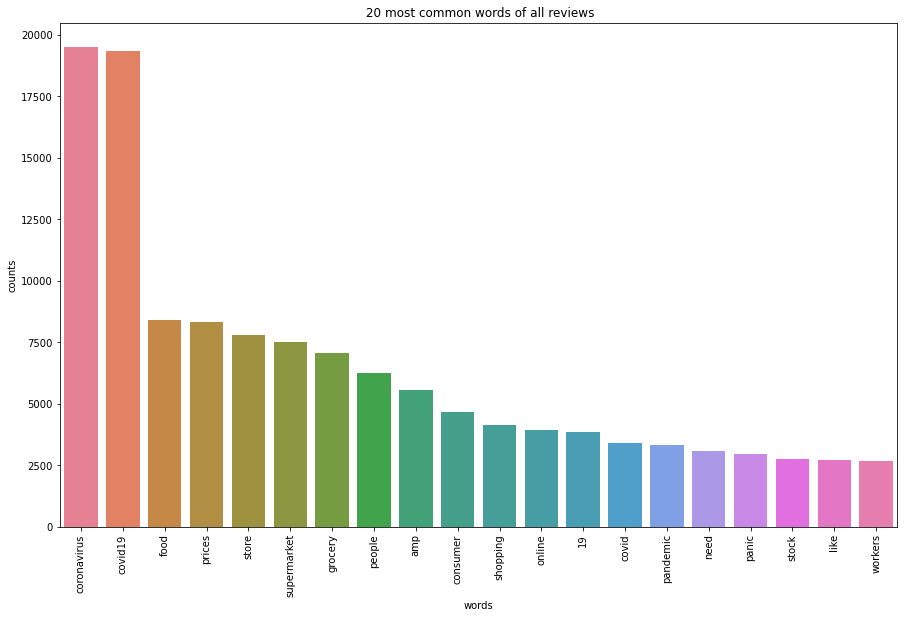

In [36]:
"""Code copyright: Vrije Universiteit Amsterdam"""

def plot_n_most_common_words(count_data, count_vectorizer, n, name):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title=f' {n} most common words of {name} reviews')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(corona_csv['OriginalTweet'])

# Visualise the n most common words
plot_n_most_common_words(count_data, count_vectorizer, 20, 'all')

C:\Users\Game PC\anaconda3\envs\schnapsen_dev\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Game PC\anaconda3\envs\schnapsen_dev\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


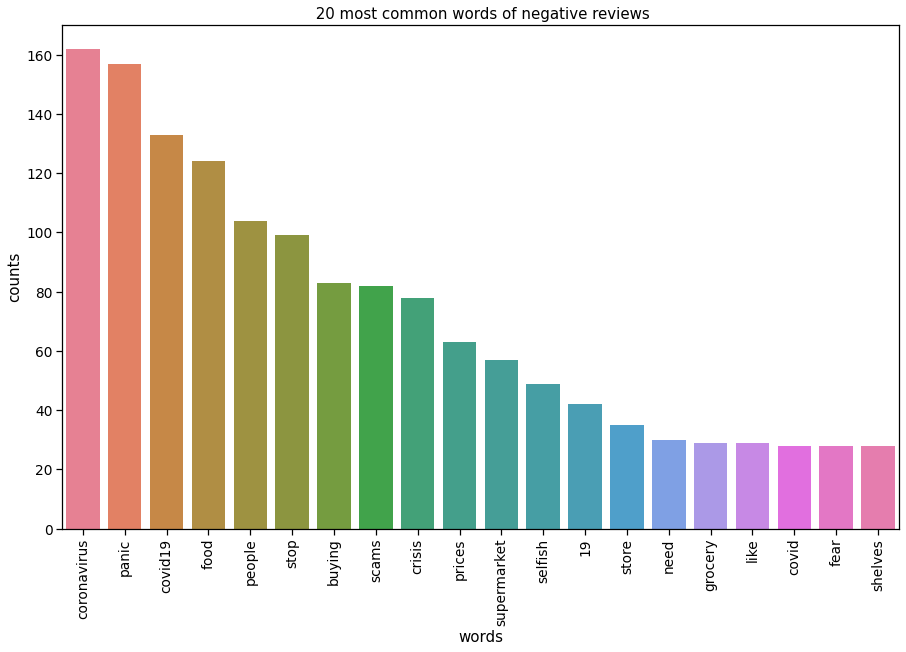

C:\Users\Game PC\anaconda3\envs\schnapsen_dev\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Game PC\anaconda3\envs\schnapsen_dev\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


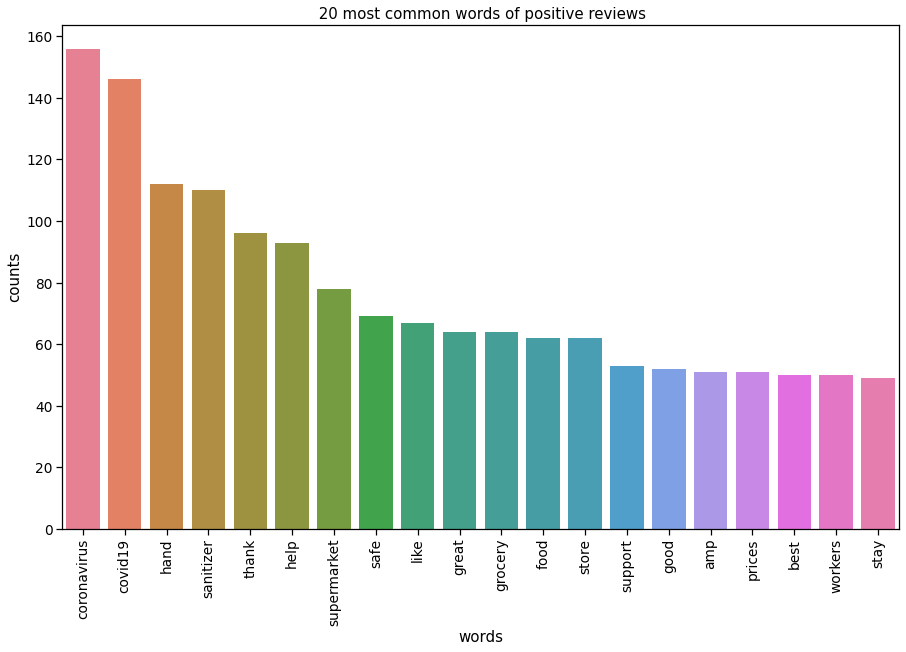

In [37]:
# Fit and transform the processed titles
count_vectorizer_negative = CountVectorizer(stop_words='english')
count_data_negative = count_vectorizer_negative.fit_transform(negative_tweets['OriginalTweet'])
plot_n_most_common_words(count_data_negative, count_vectorizer_negative, 20, 'negative')

count_vectorizer_positive = CountVectorizer(stop_words='english')
count_data_positive = count_vectorizer_positive.fit_transform(positive_tweets['OriginalTweet'])
plot_n_most_common_words(count_data_positive, count_vectorizer_positive, 20, 'positive')

In [38]:
class LDA_constructor():

    def __init__(self, data, vectorizer, n_topics = 5, num_words = 10):
        self.data = data
        self.n_topics = n_topics
        self.num_words = num_words
        self.vectorizer = vectorizer
        self.model = ' '

    def fitLDA(self):
        lda = LDA(n_components=self.n_topics)
        self.model = lda.fit(self.data)
        return self.model

    def display_topics(self):
        words = self.vectorizer.get_feature_names()
        for i, topic in enumerate(self.model.components_):
            print(f'Topic {i}#: \n {[words[i] for i in topic.argsort()[:-self.num_words - 1:-1]]}')

    def create_visual(self):
        pyLDAvis.enable_notebook()
        warnings.simplefilter("ignore", DeprecationWarning)
        warnings.simplefilter("ignore", FutureWarning)
        LDAvis_prepared = sklearn_lda.prepare(self.model, self.data, self.vectorizer)
        return LDAvis_prepared

In [39]:
# Create lda with 3 topics
lda_3_topics = LDA_constructor(count_data, count_vectorizer, 3, 10)

lda_3_topics.fitLDA()
lda_3_topics.display_topics()
lda_3_topics.create_visual()

C:\Users\Game PC\anaconda3\envs\schnapsen_dev\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 0#: 
 ['covid19', 'coronavirus', 'consumer', 'online', 'amp', 'sanitizer', 'hand', 'shopping', 'workers', '19']
Topic 1#: 
 ['prices', 'covid19', 'coronavirus', 'consumer', 'oil', 'pandemic', 'demand', 'price', 'food', 'market']
Topic 2#: 
 ['coronavirus', 'covid19', 'food', 'supermarket', 'store', 'grocery', 'people', 'panic', 'amp', 'need']


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.150970 -0.047731       1        1  47.568614
1     -0.130673 -0.074063       2        1  26.346793
0     -0.020297  0.121794       3        1  26.084593, topic_info=              Term         Freq        Total Category  logprob  loglift
70169       prices  7359.000000  7359.000000  Default  30.0000  30.0000
80371  supermarket  6836.000000  6836.000000  Default  29.0000  29.0000
13426     consumer  4133.000000  4133.000000  Default  28.0000  28.0000
25617      grocery  6410.000000  6410.000000  Default  27.0000  27.0000
79666        store  7082.000000  7082.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
27456         home   525.050437  2227.164355   Topic3  -5.9654  -0.1012
82685         time   505.969463  2263.565633   Topic3  -6.0024  -0.1544
25617      grocery   555.866079  6410.951575   Topic3  -5.9084  -1.1014
70169       prices   553.880087  7359.616259   Topic3  -5.9120  -1.2430
64331         need   489.438800  2788.037023   Topic3  -6.0357  -0.3960

[266 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
757        1  0.423008       19
757        2  0.151612       19
757        3  0.425323       19
995        1  0.220107     2020
995        2  0.651375     2020
...      ...       ...      ...
87996      1  0.788919     work
87996      2  0.017681     work
87996      3  0.193267     work
88012      1  0.350636  workers
88012      3  0.649032  workers

[447 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [40]:
# Create lda with 5 topics
lda_5_topics = LDA_constructor(count_data, count_vectorizer, 5, 10)

lda_5_topics.fitLDA()
lda_5_topics.display_topics()
lda_5_topics.create_visual()

Topic 0#: 
 ['coronavirus', 'covid19', 'store', 'grocery', 'sanitizer', 'hand', 'supermarket', 'people', 'going', 'like']
Topic 1#: 
 ['prices', 'coronavirus', 'covid19', 'oil', 'gas', 'pandemic', 'low', 'consumer', 'market', 'global']
Topic 2#: 
 ['store', 'grocery', 'supermarket', 'covid19', 'coronavirus', 'workers', 'people', 'home', 'work', 'amp']
Topic 3#: 
 ['covid19', 'consumer', 'food', '19', 'prices', 'online', 'covid', 'coronavirus', 'demand', 'shopping']
Topic 4#: 
 ['coronavirus', 'food', 'covid19', 'people', 'panic', 'supermarket', 'buying', 'toilet', 'amp', 'stock']


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.112491 -0.116613       1        1  30.537068
4     -0.068723  0.041707       2        1  20.414414
2     -0.122860 -0.093498       3        1  18.913575
0     -0.101565  0.091865       4        1  16.862784
1      0.180656  0.076539       5        1  13.272159, topic_info=              Term          Freq         Total Category  logprob  loglift
79666        store   6988.000000   6988.000000  Default  30.0000  30.0000
70169       prices   7414.000000   7414.000000  Default  29.0000  29.0000
25617      grocery   6317.000000   6317.000000  Default  28.0000  28.0000
22792         food   7628.000000   7628.000000  Default  27.0000  27.0000
14092  coronavirus  17397.000000  17397.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
86094        virus    240.763164   1140.811844   Topic5  -6.0694   0.4638
59437     lockdown    232.496712   1104.477798   Topic5  -6.1044   0.4612
82685         time    250.149718   2251.259270   Topic5  -6.0312  -0.1777
88092        world    214.779475    916.790507   Topic5  -6.1836   0.5682
4766           amp    216.743717   5007.584758   Topic5  -6.1745  -1.1205

[411 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
1          1  0.993714    000
757        1  0.788489     19
757        2  0.030294     19
757        3  0.170044     19
757        4  0.010860     19
...      ...       ...    ...
88092      1  0.254147  world
88092      2  0.309776  world
88092      3  0.121075  world
88092      4  0.080716  world
88092      5  0.234514  world

[893 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 1, 2])

In [68]:
""" TODO : Implement counter --> implemented
           Plot graphs for most common words --> implemented, but VU code is used.
           Apply LDA to entire data set --> implemented
           Possibly use machine learning to check if selected words are correctly labled positive or negative """



' TODO : Implement counter --> implemented\n           Plot graphs for most common words --> implemented, but VU code is used.\n           Apply LDA to entire data set --> implemented\n           Possibly use machine learning to check if selected words are correctly labled positive or negative '